Este notebook deseja usar redes neurais para resolver a equação diferencial (não linear) de primeira ordem. 
$$
\frac{\Psi(x)}{dx} = f(x,\Psi),
$$
$$
\Psi(0) = A.
$$

Para isto, segundo (https://www.youtube.com/watch?v=o9JaZGWekWQ) faremos com que a rede use resultados parametrizados por
$$
\Psi(x) = A + x N(x),
$$
que resolve automaticamente as condições de contorno.

Estamos então interessados em minimizar o erro na função loss
$$
\mathcal{L} = \sum_i \left[ \frac{\Psi(x_i)}{dx_i} - f(x_i,\Psi) \right].
$$
Onde $x_i$ são os pontos de colocação no domínio da solução, em geral uniformemente distribuidos.



Começando o notebook vamos importar bibliotecas que podem ser uteis e definindo a função de integração.
Neste caso iremos resolver o problema
$$
\frac{\Psi(x)}{dx} = exp\left[\frac{-x}{5}\right] \cos(x)-\frac{\Psi(x)}{5},
$$
$$
\Psi(0) = 0.
$$



Importemos algumas bibliotecas e definamos a função a ser minimizada.


In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split      
from sklearn.metrics import accuracy_score   

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

def func(x, u, u_x):
    f = u_x - tf.exp(-x/5) * tf.cos(x) + u / 5
    return f

2022-05-26 12:17:56.001826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 12:17:56.001897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
rede = keras.Sequential()

rede.add(Dense(1, input_dim=1))
rede.add(Dense(50, activation = 'tanh'))
rede.add(Dense(1))

2022-05-26 12:33:28.470204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-26 12:33:28.485802: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 12:33:28.493426: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ppgf28-Vostro-3470): /proc/driver/nvidia/version does not exist
2022-05-26 12:33:28.662928: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# Set number of data points
N_r = 500

# Set boundary
xmin = 0.
xmax = 2.
u_0 = 0.

# Lower bounds
lb = tf.constant(xmin, dtype=DTYPE)
# Upper bounds
ub = tf.constant(xmax, dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb, ub, dtype=DTYPE)

In [25]:
def get_r(model, x_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:

        x = x_r
        tape.watch(x)

        # Determine residual 
        n = model(x)

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        n_x = tape.gradient(n, x)
        
        u = x * n
        u_x = n + x * n_x

    del tape

    return func(x, u, u_x)


def compute_loss(model, x_r):
    
    # Compute phi^r
    r = get_r(model, x_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r

    return loss

def get_grad(model, x_r):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, x_r)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g


rede.compile(optimizer="Adam",
            loss=compute_loss)

rede.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
 dense_7 (Dense)             (None, 50)                100       
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [26]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([4000,8000],[1e-1,1e-2,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [27]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(rede, x_r)
    print(grad_theta)
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, rede.trainable_variables))
    
    return loss

# Number of training epochs
N = 2000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

[<tf.Tensor 'AddN_4:0' shape=(1, 1) dtype=float32>, <tf.Tensor 'gradient_tape/sequential_2/dense_6/BiasAdd/BiasAddGrad_1:0' shape=(1,) dtype=float32>, <tf.Tensor 'AddN_3:0' shape=(1, 50) dtype=float32>, <tf.Tensor 'gradient_tape/sequential_2/dense_7/BiasAdd/BiasAddGrad_1:0' shape=(50,) dtype=float32>, <tf.Tensor 'AddN_2:0' shape=(50, 1) dtype=float32>, <tf.Tensor 'gradient_tape/sequential_2/dense_8/BiasAdd/BiasAddGrad_1:0' shape=(1,) dtype=float32>]
[<tf.Tensor 'AddN_4:0' shape=(1, 1) dtype=float32>, <tf.Tensor 'gradient_tape/sequential_2/dense_6/BiasAdd/BiasAddGrad_1:0' shape=(1,) dtype=float32>, <tf.Tensor 'AddN_3:0' shape=(1, 50) dtype=float32>, <tf.Tensor 'gradient_tape/sequential_2/dense_7/BiasAdd/BiasAddGrad_1:0' shape=(50,) dtype=float32>, <tf.Tensor 'AddN_2:0' shape=(50, 1) dtype=float32>, <tf.Tensor 'gradient_tape/sequential_2/dense_8/BiasAdd/BiasAddGrad_1:0' shape=(1,) dtype=float32>]
It 00000: loss = 3.64126593e-01
It 00050: loss = 1.76439958e-03
It 00100: loss = 4.22887271e

In [30]:
import matplotlib.pyplot as plt

# Set up meshgrid
N = 600
x = np.linspace(lb, ub, N + 1)

n = rede(x)

nn = np.reshape(n, 601)

print(x.shape)
print(nn.shape)

u = x * nn


y = np.exp(-x/5)*np.sin(x)


(601,)
(601,)


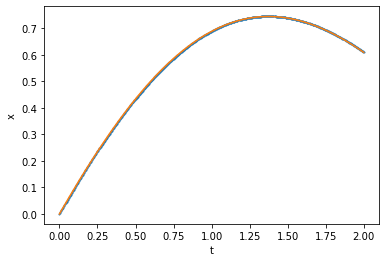

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [31]:
plt.xlabel("t")
plt.ylabel("x")
plt.plot(x, u, '.', markersize=2)
plt.plot(x, y, '-', markersize=2)


plt.show()
plt.clf()


plt.show()
plt.clf()